# Investigating how to set demand as a piecewise linear equation

In [1]:
from functools import partial
from typing import Iterable
import logging

import linopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import xarray as xr

from IPython.display import HTML, display

We start by writing a function to create some trivial network with adjustable number of hours and generators. Each generator provides 10 power with increasing marginal costs of 1, 2, ..., n

In [2]:
def create_network(num_hours=1, num_generators=2, demand=15):
    """Create a (trivially) simple, copper-plate, PyPSA network.

    :param num_hours:      Number of hourly snapshots, in the range [2, 23]
    :param num_generators: Each generator generates 10 power at marginal cost `i` for the `i`th generator
    :param demand:         Base load amount.
    """

    network = pypsa.Network()
    
    network.add("Bus", "Bus")
    network.add("Carrier", "power")
    start_hour = 0
    end_hour = start_hour + (num_hours-1)
    network.set_snapshots(pd.date_range(f"2023-01-01 {start_hour:02d}:00", f"2023-01-01 {end_hour:02d}:00", freq="H"))
    
    # add a group of increasingly costly generators
    for i in range(1, num_generators+1):
        network.add(
            'Generator', f"Generator {i}",
            bus='Bus',
            carrier='power',
            efficiency=1,
            marginal_cost=i,
            p_nom=10,
        )
    
    network.add("Load", 'electricity demand', bus='Bus', p_set=demand)
    return network

# Suppress debug/info output
logging.getLogger('pypsa.optimization.optimize').setLevel(logging.ERROR)
logging.getLogger('linopy.model').setLevel(logging.ERROR)
logging.getLogger('linopy.solvers').setLevel(logging.ERROR)
logging.getLogger('linopy.io').setLevel(logging.ERROR)
logging.getLogger('linopy.constants').setLevel(logging.ERROR)


## Example: Standard network creation and solve for future comparison

In [3]:
n = create_network(num_hours=1, num_generators=4, demand=25)
n.optimize.create_model()
n.optimize.solve_model('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1 rows, 4 cols, 4 nonzeros
1 rows, 4 cols, 4 nonzeros
Presolve : Reductions: rows 1(-8); columns 4(-0); elements 4(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(25) 0s
          1     4.5000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  4.5000000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

To generate 15 power, the cheapest generator provides its full 10, the next cheapest provides 5. The rest is off.

In [4]:
n.generators_t['p']

Generator   Generator 1  Generator 2  Generator 3  Generator 4
snapshot                                                      
2023-01-01         10.0         10.0          5.0         -0.0

Marginal price: the price of the next unit of power that would be produced. In this case, if demand would increase from 15 to 16, the next unit would come at a price of 2

In [5]:
n.buses_t['marginal_price']

Bus         Bus
snapshot       
2023-01-01  3.0

In [6]:
n.model.solution

<xarray.Dataset>
Dimensions:      (snapshot: 1, Generator: 4)
Coordinates:
  * snapshot     (snapshot) datetime64[ns] 2023-01-01
  * Generator    (Generator) object 'Generator 1' ... 'Generator 4'
Data variables:
    Generator-p  (snapshot, Generator) float64 10.0 10.0 5.0 -0.0

In [7]:
n.model.constraints.dual

<xarray.Dataset>
Dimensions:                (snapshot: 1, Generator-fix: 4, Bus: 1)
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2023-01-01
  * Generator-fix          (Generator-fix) object 'Generator 1' ... 'Generato...
  * Bus                    (Bus) object 'Bus'
Data variables:
    Generator-fix-p-lower  (snapshot, Generator-fix) float64 -0.0 -0.0 -0.0 1.0
    Generator-fix-p-upper  (snapshot, Generator-fix) float64 -2.0 -1.0 -0.0 -0.0
    Bus-nodal_balance      (snapshot, Bus) float64 3.0

## Part 1: Simple Linear Demand 

### Exploring the PyPSA Linopy model

In [8]:
network = create_network()
model = network.optimize.create_model()

Display all constraints:

In [9]:
model.constraints

for con in model.constraints:
    print(model.constraints[con])

Constraint `Generator-fix-p-lower` (snapshot: 1, Generator-fix: 2):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≥ -0.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≥ -0.0
Constraint `Generator-fix-p-upper` (snapshot: 1, Generator-fix: 2):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≤ 10.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≤ 10.0
Constraint `Bus-nodal_balance` (snapshot: 1, Bus: 1):
-----------------------------------------------------
[2023-01-01 00:00:00, Bus]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 2] = 15.0


The last constraint "Bus-nodal_balance" encodes the demand at node 'Bus'.

Note that none of the constraints show any price values... This poses a problem if we want to let demand be dependent on price.

### How can we incorporate the objective in constraints?

Luckily, it seems like this should be possible according to [this gurobi forum post](https://support.gurobi.com/hc/en-us/community/posts/360016120358-Use-objective-value-from-objective-function-as-constraint).

In short: the trick is apparently to write the objective as a separate variable, set a constraint on that variable to be the objective, point the objective to simply that variable, and then you can still use the variable in your constraints.

Let's see how far we can get in Linopy with that. First, what variables are defined and how is the objective defined?

In [10]:
model.variables

linopy.model.Variables
----------------------
 * Generator-p (snapshot, Generator)

In [11]:
model.variables["Generator-p"]

Variable (snapshot: 1, Generator: 2)
------------------------------------
[2023-01-01 00:00:00, Generator 1]: Generator-p[2023-01-01 00:00:00, Generator 1] ∈ [-inf, inf]
[2023-01-01 00:00:00, Generator 2]: Generator-p[2023-01-01 00:00:00, Generator 2] ∈ [-inf, inf]

In [12]:
model.variables.coords["snapshot"]

<xarray.DataArray 'snapshot' (snapshot: 1)>
array(['2023-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01

In [13]:
model.objective

Objective:
----------
LinearExpression: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 2 Generator-p[2023-01-01 00:00:00, Generator 2]
Sense: min
Value: None

Now let's see if we can perform the process described on the gurobi forum:
- add a variable named 'cost'
- define a constraint for it to be the current objective
- replace the explicit objective with the implicit one of the new variable

In [14]:
model.add_variables(name="cost", coords=[model.variables.coords["snapshot"]])  # the cost can vary at every timestep

Variable (snapshot: 1)
----------------------
[2023-01-01 00:00:00]: cost[2023-01-01 00:00:00] ∈ [-inf, inf]

In [15]:
model.variables

linopy.model.Variables
----------------------
 * Generator-p (snapshot, Generator)
 * cost (snapshot)

In [16]:
model.objective.expression

LinearExpression
----------------
+1 Generator-p[2023-01-01 00:00:00, Generator 1] + 2 Generator-p[2023-01-01 00:00:00, Generator 2]

In [17]:
con = model.variables["cost"] - model.objective.expression == 0
con

Constraint (unassigned) (snapshot: 1):
--------------------------------------
[2023-01-01 00:00:00]: +1 cost[2023-01-01 00:00:00] - 1 Generator-p[2023-01-01 00:00:00, Generator 1] - 2 Generator-p[2023-01-01 00:00:00, Generator 2] = -0.0

In [18]:
model.add_constraints(con, name="cost")

Constraint `cost` (snapshot: 1):
--------------------------------
[2023-01-01 00:00:00]: +1 cost[2023-01-01 00:00:00] - 1 Generator-p[2023-01-01 00:00:00, Generator 1] - 2 Generator-p[2023-01-01 00:00:00, Generator 2] = -0.0

In [19]:
model.objective = 1*model.variables["cost"]  # have to multiply by 1 to force the 'variable' into a 'linear expression'

Let's see if the model is still valid and will solve:

In [20]:
model.solve('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-6); columns 0(-3); elements 0(-9) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  2.0000000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

🎉🎉🎉

### Making demand dynamic in the linear model

Now that we know how to adjust the model, we can try replacing the demand constraint by our own that defines some flexible demand. We'll start simple with a single linear equation.

In [21]:
new_demand = -0.5*model.variables["cost"] + 20  # needs to be -x + 20 instead of 20 - x for operator order reasons.
new_demand

LinearExpression (snapshot: 1):
-------------------------------
[2023-01-01 00:00:00]: -0.5 cost[2023-01-01 00:00:00] + 20

We want the above `new_demand` expression to replace the fixed value `15` from the previously defined constraint. Here's the original constraint as a reminder:

In [22]:
model.constraints["Bus-nodal_balance"]

Constraint `Bus-nodal_balance` (snapshot: 1, Bus: 1):
-----------------------------------------------------
[2023-01-01 00:00:00, Bus]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 2] = 15.0

We can make a new expression by taking the left-hand-side of this equality and setting it equal to our new demand. Linopy takes care of reordering this nicely:

In [23]:
new_constraint = model.constraints["Bus-nodal_balance"].lhs == new_demand
new_constraint

Constraint (unassigned) (snapshot: 1, Bus: 1):
----------------------------------------------
[2023-01-01 00:00:00, Bus]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 2] + 0.5 cost[2023-01-01 00:00:00] = 20.0

Now all that's left is to remove the old constraint and replace it with the new one:

In [24]:
model.remove_constraints("Bus-nodal_balance")
model.add_constraints(new_constraint, name="Bus-nodal_balance")

Constraint `Bus-nodal_balance` (snapshot: 1, Bus: 1):
-----------------------------------------------------
[2023-01-01 00:00:00, Bus]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 2] + 0.5 cost[2023-01-01 00:00:00] = 20.0

Let's see if it solves now... 🤞

In [25]:
model.solve('highs')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 3 cols, 6 nonzeros
2 rows, 3 cols, 6 nonzeros
Presolve : Reductions: rows 2(-4); columns 3(-0); elements 6(-4)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1500); Du: 1(1) 0s
          2     1.5000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  1.5000000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

🎉🎉🎉

### Can we generalize the procedure?

Now that we've done the steps one-by-one, it needs to be generalized into a single function to be repeatable for different models and different dynamic demands (multi-part piecewise linear is to follow later).

Here's all the code that actually executed something
```python
network = create_network()
model = network.optimize.create_model()

## create the separate 'cost' variable
model.add_variables(name="cost", coords=[model.variables.coords["snapshot"]])  # the cost can vary at every timestep
con = model.variables["cost"] - model.objective.expression == 0
model.add_constraints(con, name="cost")
model.objective = 1*model.variables["cost"]  # have to multiply by 1 to force the 'variable' into a 'linear expression'

## create dynamic demand based on 'cost' variable
new_demand = -0.5*model.variables["cost"] + 20  # needs to be -x + 20 instead of 20 - x for operator order reasons.
new_constraint = model.constraints["Bus-nodal_balance"].lhs == new_demand
model.remove_constraints("Bus-nodal_balance")
model.add_constraints(new_constraint, name="Bus-nodal_balance")

model.solve('highs')  # or network.optimize()
```

Looking at the code above, there's two dynamic parts that need to be taken into account:
- The new demand equation
- the bus name, implicit in the constraint name(s)

For now, we keep the demand a simple linear equation `y = ax + b` that can be defined by the slope `a` and intercept `b`. In this context, `b` is the maximum demand at zero cost, and `a < 0` is the decrease in demand for every unit-increase in cost.

In [26]:
def add_objective_as_cost_variable(model: linopy.Model):
    """Take the objective of the model and turn it into a separate variable named 'cost'"""
    model.add_variables(name="cost", coords=[model.variables.coords["snapshot"]])  # the cost can vary at every timestep
    con = model.variables["cost"] == model.objective.expression  # cost - obj.expression == 0
    model.add_constraints(con, name="cost")
    model.objective = 1*model.variables["cost"]  # have to multiply by 1 to force the 'variable' into a 'linear expression'


def make_demand_cost_linear(model: linopy.Model, demand_equations: dict[str, tuple[int, int]]):
    """Make the demand constraints for the given model dynamic

    Given a set of demand equations and associated busses, update the
    demand constraint at each bus to become dynamic based on the cost.

    `demand_equations` is a dictionary of the format
        { 'bus': (slope, y_intercept) }
    """    
    ## create dynamic demand based on 'cost' variable
    for bus, (slope, y_intercept) in demand_equations.items():
        new_demand = slope*model.variables["cost"] + y_intercept
        new_constraint = model.constraints[f"{bus}-nodal_balance"].lhs == new_demand
        model.remove_constraints(f"{bus}-nodal_balance")
        model.add_constraints(new_constraint, name=f"{bus}-nodal_balance")

    return model  # for good measure

Now let's actually run this for a full model and closely examine the results.

To make our lives easier, we construct an example demand curve that intersects the total cost at a nice integer value. With the simple network defined before, we have generators generating 10 power each, at costs of 1, 2, ..., etc. If we set `demand = 40 - 1/3*cost`, that neatly results in a load of 25.

Note that the equation has been rewritten to the form `cost = 120 - 3*x` to match the axis setup based on the marginal cost of the generators.

#### Visualizing demand function

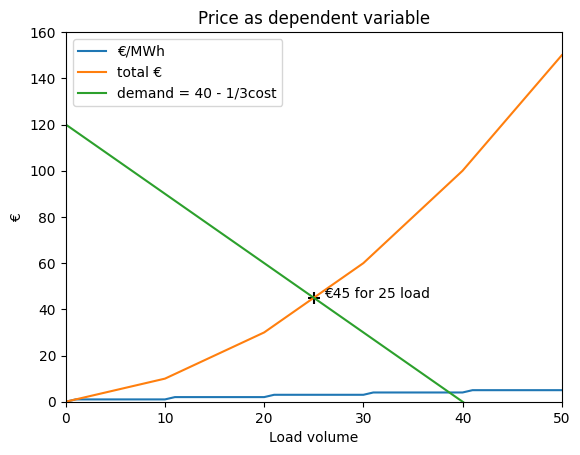

In [27]:
marginal_costs = np.concatenate(([0], np.repeat(np.arange(1,6), 10)))
total_cost = np.cumsum(marginal_costs)

costmax = 160
cost = np.arange(costmax+1)
xmax = 50
x = np.arange(xmax+1)

demands = {
    # 'demand = 50 - 0.2cost': 250 - 5*x,
    # 'demand = 42 - 0.2cost': 210 - 5*x,
    'demand = 40 - 1/3cost': 120 - 3*x,
    # 'demand = 39 - 1/3cost': 60 - 3*x,
    # 'demand = 38 - 1/3cost': 15 - 3*x,
}

plt.ylabel('€')
plt.xlabel('Load volume')
plt.title('Price as dependent variable')
plt.ylim([0, costmax])
plt.xlim([0, xmax])

plt.plot(marginal_costs, label='€/MWh')
plt.plot(total_cost, label='total €')
for label, demand in demands.items():
    plt.plot(demand, label=label)

plt.scatter(25, 45, s=64, marker='+', color='black')
plt.text(26, 45, "€45 for 25 load")

plt.legend(loc=0)
plt.show()

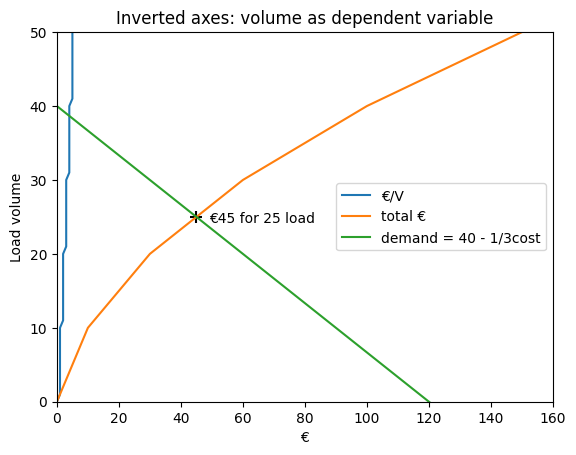

In [28]:
marginal_costs = np.concatenate(([0], np.repeat(np.arange(1,6), 10)))
total_cost = np.cumsum(marginal_costs)

costmax = 160
cost = np.arange(costmax+1)
xmax = 50
x = np.arange(xmax+1)

demands = {
    # 'demand = 50 - 0.2cost': 250 - 5*x,
    # 'demand = 42 - 0.2cost': 210 - 5*x,
    'demand = 40 - 1/3cost': 40 - 1/3*cost,
    # 'demand = 39 - 1/3cost': 60 - 3*x,
    # 'demand = 38 - 1/3cost': 15 - 3*x,
}

plt.xlabel('€')
plt.ylabel('Load volume')
plt.title('Inverted axes: volume as dependent variable')
plt.xlim([0, costmax])
plt.ylim([0, xmax])

plt.plot(marginal_costs, x, label='€/V')
plt.plot(total_cost, x, label='total €')
for label, demand in demands.items():
    plt.plot(demand, label=label)

plt.scatter(45, 25, s=64, marker='+', color='black')
plt.text(49, 24.2, "€45 for 25 load")

plt.legend(loc=0)
plt.show()

#### Running example

Let's plug this demand equation into the network, solve it and examine the results to confirm that 25 power is consumed at a total cost of €45:

In [29]:
network = create_network(num_hours=1, num_generators=4)
model = network.optimize.create_model()
demand_equations = {'Bus': (-(1/3), 40)}  # demand at 'Bus' is 40 - 1/3*cost
add_objective_as_cost_variable(model)
model = make_demand_cost_linear(model, demand_equations)
network.optimize.solve_model('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1333.33); Du: 1(1) 0s
          2     4.5000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  4.5000000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

In [30]:
print(network.model.constraints.dual['cost'])
print(network.model.constraints.dual['Bus-nodal_balance'])

<xarray.DataArray 'cost' (snapshot: 1)>
array([0.5])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
<xarray.DataArray 'Bus-nodal_balance' (snapshot: 1, Bus: 1)>
array([[1.5]])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
  * Bus       (Bus) object 'Bus'


In [31]:
print("Model Solution:")
display(network.model.solution)

print("Generator dispatch:")
display(network.generators_t['p'])

print("Marginal prices:")
display(network.buses_t['marginal_price'])

Model Solution:


<xarray.Dataset>
Dimensions:      (snapshot: 1, Generator: 4)
Coordinates:
  * snapshot     (snapshot) datetime64[ns] 2023-01-01
  * Generator    (Generator) object 'Generator 1' ... 'Generator 4'
Data variables:
    Generator-p  (snapshot, Generator) float64 10.0 10.0 5.0 -0.0
    cost         (snapshot) float64 45.0

Generator dispatch:


Generator   Generator 1  Generator 2  Generator 3  Generator 4
snapshot                                                      
2023-01-01         10.0         10.0          5.0         -0.0

Marginal prices:


Bus         Bus
snapshot       
2023-01-01  1.5

The reported cost in the solution is indeed €45, and the generator dispatch is indeed 10+10+5 = 25. But something interesting has happened at the marginal prices. Normally, we would expect a value of 3, since each unit of extra load of generator 3 will cost an additional €3. But for some reason a marginal cost of 1.5 is reported here.

### Explaining Marginal Cost

The non-integer marginal costs obviously have something to do with the changes we made to the constraints. Apparently, we've made such a change that the 'unit' being used for the marginal cost calculation by the linear solver is no longer directly the generators, but includes our dynamic demand too.

This makes sense, as we have set the objective to the 'cost' variable, and have defined it as the combination of the generators and the cost.

In [32]:
for con in network.model.constraints:
    print(network.model.constraints[con])
    print()

Constraint `Generator-fix-p-lower` (snapshot: 1, Generator-fix: 4):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≥ -0.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≥ -0.0
[2023-01-01 00:00:00, Generator 3]: +1 Generator-p[2023-01-01 00:00:00, Generator 3] ≥ -0.0
[2023-01-01 00:00:00, Generator 4]: +1 Generator-p[2023-01-01 00:00:00, Generator 4] ≥ -0.0

Constraint `Generator-fix-p-upper` (snapshot: 1, Generator-fix: 4):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≤ 10.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≤ 10.0
[2023-01-01 00:00:00, Generator 3]: +1 Generator-p[2023-01-01 00:00:00, Generator 3] ≤ 10.0
[2023-01-01 00:00:00, Generator 4]: +1 Generator-p[2023-01-01 00:00:00, Generator 4

Let's throw another couple of dynamic response curves at the solver and see if we can find a pattern in the reported marginal costs. We'll keep track of the reported dual value for both the `bus-nodal_balance` and `cost` constraints.

In [33]:
demand_equations = [
    {'Bus': (-.2, 50)},
    {'Bus': (-.2, 41)},
    {'Bus': (-(1/3), 40)},
    {'Bus': (-(1/3), 20)},
    {'Bus': (-(1/3), 5)},
]

duals = []

for demand_equation in demand_equations:
    network = create_network(num_hours=1, num_generators=4)
    model = network.optimize.create_model()
    add_objective_as_cost_variable(model)
    model = make_demand_cost_linear(model, demand_equation)
    network.optimize.solve_model('highs', io_api='direct')
    display(network.buses_t['marginal_price'])
    display(network.model.solution['cost'].values[0])
    duals.append(
        (network.model.constraints.dual['Bus-nodal_balance'].values[0][0],
         network.model.constraints.dual['cost'].values[0])
    )

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1200); Du: 1(1) 0s
          2     7.7777777778e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  7.7777777778e+01
HiGHS run time      :          0.00


Bus              Bus
snapshot            
2023-01-01  2.222222

77.77777777777777

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1200); Du: 1(1) 0s
          2     5.8125000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  5.8125000000e+01
HiGHS run time      :          0.00


Bus           Bus
snapshot         
2023-01-01  1.875

58.125

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1333.33); Du: 1(1) 0s
          2     4.5000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  4.5000000000e+01
HiGHS run time      :          0.00


Bus         Bus
snapshot       
2023-01-01  1.5

45.0

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1333.33); Du: 1(1) 0s
          2     1.8000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  1.8000000000e+01
HiGHS run time      :          0.00


Bus         Bus
snapshot       
2023-01-01  1.2

18.0

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1333.33); Du: 1(1) 0s
          2     3.7500000000e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  3.7500000000e+00
HiGHS run time      :          0.00


Bus          Bus
snapshot        
2023-01-01  0.75

3.75

In [34]:
print('bus-nodal, cost')
display(duals)

bus-nodal, cost


[(2.2222222222222223, 0.5555555555555556),
 (1.875, 0.625),
 (1.5, 0.5),
 (1.2000000000000002, 0.6),
 (0.75, 0.75)]

#### So... what happened here?

First a quick reminder that the marginal price is normally found as the _dual_ of the `Bus-nodal` constraint.

> _The rate at which the objective function value will grow as the right-hand side or constant term of a constraint is slightly increased is known as the dual price of the constraint._
> 
> source: [codingdeeply.com](https://www.codingdeeply.com/how-to-calculate-dual-price-in-linear-programming/) (d.d. 2023-12-04)

The following overview should give an indication of what happens based on the five specified examples:

| Demand equation | Demand Slope | Total Cost | Marginal Cost | Reported `Bus-nodal` dual | Reported `cost` dual |
|:----------------|-------------:|-----------:|--------------:|--------------------------:|---------------------:|
| 50 - 1/5 * cost | 1/5          | 77.777     | 4             | 2.222                     | 0.555                |
| 41 - 1/5 * cost | 1/5          | 58.125     | 3             | 1.875                     | 0.625                |  |40 - 1/3  *csts  |1 3          | 45.000     | 3             | 1.500                    | 0.500                |t
| 20  -1/3  *csts  |1 3          | 18.000     | 2             | 1.200                    | 0.600                |t
|  5  -1/3  *csts  |1 3          |  3.750     | 1             | 0.750                    | 0.750                ||

At first, this may seem rather confusing, but the reported marginal cost can be calculated based on the demand slope and the actual marginal cost:

$\text{reported} = \text{marginal cost} * \dfrac{1/ \text{demand slope} }{1/ \text{demand slope} + \text{marginal cost} }$

For example: $2.222 = 4 * \dfrac{5}{4+5=9}$, $1.5 = 3 * \dfrac{3}{3+3=6}$ and $0.75 = 1 * \dfrac{3}{3+1=4}

<br>$But perhaps simpler is the relationship between the `Bus-nodal` and `cost` duals:

$\text{marginal cost} = \dfrac{\text{Bus-nodal dual}}{\text{cost dual}}$t

In [35]:
for bus, cost in duals:
    print(bus / cost)

4.0
3.0
3.0
2.0000000000000004
1.0


As shown above by the combination of duals: the bus dual divided by the cost dual gives us the actual marginal cost at that bus.

Explanation:
1. The `Bus-nodal_balance` constraint in short is `sum(generators@Bus) + slope*cost == y_intercept`.<br>
   The corresponding dual therefore is the combined amount of extra power and slope-adjusted cost if the y_intersept of the dynamic demand constraint is raised by one.<br>
   Since practically speaking, only one of the generators will increase, the increase is divided among the generators and the `slope*cost`, where the increase in cost actually depends on the marginal cost.

2. The `cost` constraint in short is `cost - sum(price*generators@Bus) == 0` (or in other terms `cost = sum(price*generators@Bus`).<br>
   The cost dual is the amount of extra power generated if the difference were 1 higher, so if the total cost were 1 higher.

The two constraints are very similar, with the difference being that `Bus-nodal_balance` does include the demand `slope`, but does not include the generators' `price`, with the reverse being true for the `cost` constraint.

**TODO** It should now be possible to properly define both the value and unit of the each constraint's dual, and to then divide one by the other to obtain the marginal price + value.

For now, we'll ignore this exercise, and simply assume that we can find the 'traditional' marginal price by dividing the `bus-nodal` dual by the `cost` dual.

##### Example for determining the dual of constraint 1.

In [36]:
network = create_network(num_hours=1, num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)
model = make_demand_cost_linear(model, {'Bus': (-(1/3), 41)})
network.optimize.solve_model('highs', io_api='direct')
display(network.buses_t['marginal_price'])
display(network.model.solution['cost'].values[0])
print(network.model.constraints.dual['cost'])
print(network.model.constraints.dual['Bus-nodal_balance'])

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1333.33); Du: 1(1) 0s
          2     4.6500000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  4.6500000000e+01
HiGHS run time      :          0.00


Bus         Bus
snapshot       
2023-01-01  1.5

46.5

<xarray.DataArray 'cost' (snapshot: 1)>
array([0.5])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
<xarray.DataArray 'Bus-nodal_balance' (snapshot: 1, Bus: 1)>
array([[1.5]])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
  * Bus       (Bus) object 'Bus'


Objective value is now 46.5 instead of 45, an increase of 1.5.

##### Example for determining the dual of constraint 2.

In [37]:
network = create_network(num_hours=1, num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)
model = make_demand_cost_linear(model, {'Bus': (-(1/3), 40)})

new_cost = model.constraints['cost'].lhs == 1
model.remove_constraints("cost")
model.add_constraints(new_cost, name="cost")

network.optimize.solve_model('highs', io_api='direct')
display(network.buses_t['marginal_price'])
display(network.model.solution['cost'].values[0])
print(network.model.constraints.dual['cost'])
print(network.model.constraints.dual['Bus-nodal_balance'])

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 10 nonzeros
2 rows, 5 cols, 10 nonzeros
Presolve : Reductions: rows 2(-8); columns 5(-0); elements 10(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 2(1333.33); Du: 1(1) 0s
          2     4.5500000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  4.5500000000e+01
HiGHS run time      :          0.00


Bus         Bus
snapshot       
2023-01-01  1.5

45.50000000000001

<xarray.DataArray 'cost' (snapshot: 1)>
array([0.5])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
<xarray.DataArray 'Bus-nodal_balance' (snapshot: 1, Bus: 1)>
array([[1.5]])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
  * Bus       (Bus) object 'Bus'


Objective value is now 45.5, an increase of 0.5

## Part 2: Piecewise Linear Demand

This part is just a quick illustration of what piecewise linear demand would look like. Let's make two cases by adding two extra linear constraints to the previous example: one binding, one not. The figure below shows the extra constraints.

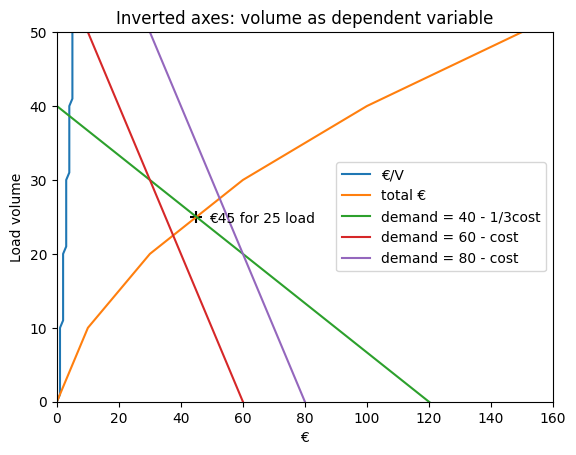

In [38]:
marginal_costs = np.concatenate(([0], np.repeat(np.arange(1,6), 10)))
total_cost = np.cumsum(marginal_costs)

costmax = 160
cost = np.arange(costmax+1)
xmax = 50
x = np.arange(xmax+1)

demands = {
    'demand = 40 - 1/3cost': 40 - 1/3*cost,
    'demand = 60 - cost': 60 - cost,
    'demand = 80 - cost': 80 - cost,
}

plt.xlabel('€')
plt.ylabel('Load volume')
plt.title('Inverted axes: volume as dependent variable')
plt.xlim([0, costmax])
plt.ylim([0, xmax])

plt.plot(marginal_costs, x, label='€/V')
plt.plot(total_cost, x, label='total €')
for label, demand in demands.items():
    plt.plot(demand, label=label)

plt.scatter(45, 25, s=64, marker='+', color='black')
plt.text(49, 24.2, "€45 for 25 load")

plt.legend(loc=0)
plt.show()

To incorporate these multiple constraints, we need to make small changes to the previously defined `make_demand_cost_linear` function. Because any one of the piecewise linear constraints can be binding, we first have to relax the constraint from `==` to `>=`. Next we have to make the demand equations a sequence of linear pieces. Note that in this case, we simply extend it to accept a list of linear equations. Note that this is the easiest way to incorporate such a piecewise linear equation into the model, 

In [39]:
def make_demand_cost_piecewise_linear(model: linopy.Model, demand_equations: dict[str, list[tuple[int, int]]]):
    """Make the demand constraints for the given model dynamic

    Given a set of piecewise linear demand equations and associated busses,
    update the demand constraint at each bus to become dynamic based on the cost.

    `demand_equations` is a dictionary of the format
        { 'bus': [(slope_1, y_intercept_1), (slope_2, y_intercept_2), ...] }
    """
    ## create the separate 'cost' variable
    model.add_variables(name="cost", coords=[model.variables.coords["snapshot"]])  # the cost can vary at every timestep
    con = model.variables["cost"] == model.objective.expression  # cost - obj.expression == 0
    model.add_constraints(con, name="cost")
    model.objective = 1*model.variables["cost"]  # have to multiply by 1 to force the 'variable' into a 'linear expression'

    ## create dynamic demand based on 'cost' variable
    for bus, equations in demand_equations.items():
        for i, (slope, y_intercept) in enumerate(equations):
            new_demand = slope*model.variables["cost"] + y_intercept
            new_constraint = model.constraints[f"{bus}-nodal_balance"].lhs >= new_demand
            model.add_constraints(new_constraint, name=f"{bus}-nodal_balance_{i}")
        model.remove_constraints(f"{bus}-nodal_balance")

    return model  # for good measure

In [40]:
network = create_network(num_hours=1, num_generators=4)
model = network.optimize.create_model()
demand_equations = {'Bus': [(-1/3, 40), (-1, 60)]}  # demand at 'Bus' is 40 - 1/3*cost
model = make_demand_cost_piecewise_linear(model, demand_equations)
network.optimize.solve_model('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 5 cols, 15 nonzeros
3 rows, 5 cols, 15 nonzeros
Presolve : Reductions: rows 3(-8); columns 5(-0); elements 15(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 3(2333.33); Du: 1(1) 0s
          3     4.5000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 3
Objective value     :  4.5000000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

In [41]:
network = create_network(num_hours=1, num_generators=4)
model = network.optimize.create_model()
demand_equations = {'Bus': [(-1/3, 40), (-1, 80)]}  # demand at 'Bus' is 40 - 1/3*cost
model = make_demand_cost_piecewise_linear(model, demand_equations)
network.optimize.solve_model('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 5 cols, 15 nonzeros
3 rows, 5 cols, 15 nonzeros
Presolve : Reductions: rows 3(-8); columns 5(-0); elements 15(-8)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000000e+03 Ph1: 3(2333.33); Du: 1(1) 0s
          2     5.2500000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  5.2500000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

## Part 3: Multiple Demands, Snapshots & Buses

To properly apply the piecewise linear demands we've established, it's no good if we can only use a single demand source, snapshot or a single bus. Let's tackle each in order to see if and how that may complicate the actual final implementations

### Multiple Demands

We start simple: if we add another demand of 10, how is that encoded into the linopy model?

In [42]:
network = create_network()
network.add("Load", 'electricity demand 2', bus='Bus', p_set=10)
model = network.optimize.create_model()

for con in model.constraints:
    print(model.constraints[con])

Constraint `Generator-fix-p-lower` (snapshot: 1, Generator-fix: 2):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≥ -0.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≥ -0.0
Constraint `Generator-fix-p-upper` (snapshot: 1, Generator-fix: 2):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≤ 10.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≤ 10.0
Constraint `Bus-nodal_balance` (snapshot: 1, Bus: 1):
-----------------------------------------------------
[2023-01-01 00:00:00, Bus]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 2] = 25.0


Perhaps not too surprising: the demands simply get added together. This will work the same for dynamic demand. Reverse-computing how much demand was actually satisfied per specified demand is easy enough: we can find the price per node and plug that into the piecewise linear demand. This is only a minor extra step compared to having only a single source of demand.

### Multiple Snapshots

Let's extend the number of snapshots to 3 and still add the extra demand

In [43]:
network = create_network(num_hours=3)
network.add("Load", 'electricity demand 2', bus='Bus', p_set=10)
model = network.optimize.create_model()

for con in model.constraints:
    print(model.constraints[con])

Constraint `Generator-fix-p-lower` (snapshot: 3, Generator-fix: 2):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≥ -0.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≥ -0.0
[2023-01-01 01:00:00, Generator 1]: +1 Generator-p[2023-01-01 01:00:00, Generator 1] ≥ -0.0
[2023-01-01 01:00:00, Generator 2]: +1 Generator-p[2023-01-01 01:00:00, Generator 2] ≥ -0.0
[2023-01-01 02:00:00, Generator 1]: +1 Generator-p[2023-01-01 02:00:00, Generator 1] ≥ -0.0
[2023-01-01 02:00:00, Generator 2]: +1 Generator-p[2023-01-01 02:00:00, Generator 2] ≥ -0.0
Constraint `Generator-fix-p-upper` (snapshot: 3, Generator-fix: 2):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≤ 10.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2]

Not too surprising, the number of constraints increases to set constraints per snapshot.
Does the previously defined 'make_demand_cost_linear' function still work without any adjustments required?

In [44]:
network = create_network(num_hours=3, num_generators=4)
network.add("Load", 'electricity demand 2', bus='Bus', p_set=10)
model = network.optimize.create_model()
demand_equations = {'Bus': (-(1/3), 40)}  # demand at 'Bus' is 40 - 1/3*cost
add_objective_as_cost_variable(model)
model = make_demand_cost_linear(model, demand_equations)
network.optimize.solve_model('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
6 rows, 15 cols, 54 nonzeros
6 rows, 15 cols, 54 nonzeros
Presolve : Reductions: rows 6(-24); columns 15(-0); elements 54(-24)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.0000000000e+03 Ph1: 6(4000); Du: 3(3) 0s
          7     2.1000000000e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  2.1000000000e+02
HiGHS run time      :          0.00


('ok', 'optimal')

In [45]:
for con in model.constraints:
    print(model.constraints[con])

Constraint `Generator-fix-p-lower` (snapshot: 3, Generator-fix: 4):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≥ -0.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≥ -0.0
[2023-01-01 00:00:00, Generator 3]: +1 Generator-p[2023-01-01 00:00:00, Generator 3] ≥ -0.0
[2023-01-01 00:00:00, Generator 4]: +1 Generator-p[2023-01-01 00:00:00, Generator 4] ≥ -0.0
[2023-01-01 01:00:00, Generator 1]: +1 Generator-p[2023-01-01 01:00:00, Generator 1] ≥ -0.0
[2023-01-01 01:00:00, Generator 2]: +1 Generator-p[2023-01-01 01:00:00, Generator 2] ≥ -0.0
[2023-01-01 01:00:00, Generator 3]: +1 Generator-p[2023-01-01 01:00:00, Generator 3] ≥ -0.0
[2023-01-01 01:00:00, Generator 4]: +1 Generator-p[2023-01-01 01:00:00, Generator 4] ≥ -0.0
[2023-01-01 02:00:00, Generator 1]: +1 Generator-p[2023-01-01 02:00:00, Generator 1] ≥ -0.0
[2023-01-01 02:00:00, Generator 2]: 

Yep, this still works too: additional snapshots does not complicate the procedure too much 🎉

### Multiple Buses

By itself, multiple buses aren't that interesting either: Each bus will have its separate constraints on generation and consumption, which will now include transmission constraints. The interesting thing however is to see what happens to the dual values after solving.

Remember from Part 1 that the traditionally expected dual value at the bus had to be adjusted with the dual value of the separate `cost` constraint. My expectation is that this will be independently true for each bus. Hopefully we can confirm this without needing dynamic demand: just making the cost constraint explicit should be enough in a two-bus setup.

In [46]:
def create_two_bus_network(num_hours=1, num_generators=2, demand=15):
    """Create a (trivially) simple, copper-plate, PyPSA network.

    :param num_hours:      Number of hourly snapshots, in the range [2, 23]
    :param num_generators: Each generator generates 10 power at marginal cost `i` for the `i`th generator
    :param demand:         Base load amount.
    """

    network = pypsa.Network()
    
    network.add("Bus", "Bus1")
    network.add("Bus", "Bus2")
    network.add("Line", "line", bus0="Bus1", bus1="Bus2", s_nom=1000, x=0.01, r=0.01)
    network.add("Carrier", "power")
    start_hour = 0
    end_hour = start_hour + (num_hours-1)
    network.set_snapshots(pd.date_range(f"2023-01-01 {start_hour:02d}:00", f"2023-01-01 {end_hour:02d}:00", freq="H"))
    
    # add a group of increasingly costly generators
    for i in range(1, num_generators+1):
        network.add(
            'Generator', f"Generator {i}",
            bus=f'Bus{i%2 + 1}',
            carrier='power',
            efficiency=1,
            marginal_cost=i,
            p_nom=10,
        )
    
    network.add("Load", 'electricity demand', bus='Bus1', p_set=demand)
    return network

In [47]:
network2 = create_two_bus_network(num_generators=4)
model = network2.optimize.create_model()

add_objective_as_cost_variable(model)

network2.optimize.solve_model('highs', io_api='direct')

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 5 cols, 6 nonzeros
1 rows, 4 cols, 4 nonzeros
1 rows, 4 cols, 4 nonzeros
Presolve : Reductions: rows 1(-12); columns 4(-2); elements 4(-17)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(15) 0s
          1     2.0000000000e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  2.0000000000e+01
HiGHS run time      :          0.00


('ok', 'optimal')

In [48]:
print(
    network2.model.constraints.dual['Bus-nodal_balance'],
    network2.model.constraints.dual['cost']
)

<xarray.DataArray 'Bus-nodal_balance' (Bus: 2, snapshot: 1)>
array([[2.],
       [2.]])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01
  * Bus       (Bus) object 'Bus1' 'Bus2' <xarray.DataArray 'cost' (snapshot: 1)>
array([1.])
Coordinates:
  * snapshot  (snapshot) datetime64[ns] 2023-01-01


In [49]:
for con in model.constraints:
    print(model.constraints[con])

Constraint `Generator-fix-p-lower` (snapshot: 1, Generator-fix: 4):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≥ -0.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≥ -0.0
[2023-01-01 00:00:00, Generator 3]: +1 Generator-p[2023-01-01 00:00:00, Generator 3] ≥ -0.0
[2023-01-01 00:00:00, Generator 4]: +1 Generator-p[2023-01-01 00:00:00, Generator 4] ≥ -0.0
Constraint `Generator-fix-p-upper` (snapshot: 1, Generator-fix: 4):
-------------------------------------------------------------------
[2023-01-01 00:00:00, Generator 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] ≤ 10.0
[2023-01-01 00:00:00, Generator 2]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] ≤ 10.0
[2023-01-01 00:00:00, Generator 3]: +1 Generator-p[2023-01-01 00:00:00, Generator 3] ≤ 10.0
[2023-01-01 00:00:00, Generator 4]: +1 Generator-p[2023-01-01 00:00:00, Generator 4]

Hmm, nope, the dual for the cost is simply 1. This actually makes sense, since there's nothing 'external' forcing 'cost' to change in a different way than it would without dynamic demand.

Note also that the `Bus-nodal_balance` is still just the single constraint name, and that there's a separate entry for each bus. This actually makes sense, but doesn mean our previous implementation was wrong of `make_demand_cost_linear` was wrong. 

First, this means we have to fix that mistake. This turns out to be harder than it may seem...

#### First try: assign to `model.constraints`

The first try would be to index the constraints to only select the `Bus-nodal_balance` for the particular bus and assign the new constraints to those indices.
Because of linopy's architecture on top of xarray, that does not work and actually gives a SyntaxError. The linopy `Constraint` object is built on top of an xarray Dataset, for which `.sel()` returns a new copy. For a DataArray, `.sel()` can be used to assign values.

In [50]:
network = create_two_bus_network(num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)

new_demand = (-1/3)*model.variables["cost"] + 40
new_constraint = model.constraints["Bus-nodal_balance"].sel(Bus=bus).lhs == new_demand
model.constraints["Bus-nodal_balance"].sel(Bus="Bus1") = new_constraint

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (1373066465.py, line 7)

In [51]:
network = create_two_bus_network(num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)

new_demand = (-1/3)*model.variables["cost"] + 40
new_constraint = model.constraints["Bus-nodal_balance"].sel(Bus='Bus1').lhs == new_demand
# model.constraints["Bus-nodal_balance"].sel(Bus="Bus1") = new_constraint

TODO: add explanation here

In [52]:
def make_demand_cost_linear(model: linopy.Model, demand_equations: dict[str, tuple[int, int]]):
    """Make the demand constraints for the given model dynamic

    Given a set of demand equations and associated busses, update the
    demand constraint at each bus to become dynamic based on the cost.

    `demand_equations` is a dictionary of the format
        { 'bus': (slope, y_intercept) }
    """
    # Create separate named constraints per bus
    for bus in model.constraints['Bus-nodal_balance'].coords["Bus"].values:
        # use demand equation if present
        if bus in demand_equations:
            slope, y_intercept = demand_equations[bus]
            new_demand = slope*model.variables["cost"] + y_intercept
            new_constraint = model.constraints["Bus-nodal_balance"].sel(Bus=bus).lhs == new_demand
        else:  # carry over original constraint if no demand equation is specified
            new_constraint = model.constraints["Bus-nodal_balance"].sel(Bus=bus)
        model.add_constraints(new_constraint, name=f"{bus}-nodal_balance")

    # remove original constraint
    model.remove_constraints("Bus-nodal_balance")

    return model  # for good measure

In [53]:
cons = []
for bus in model.constraints['Bus-nodal_balance'].coords["Bus"].values:
    # use demand equation if present
    if bus in demand_equations:
        slope, y_intercept = demand_equations[bus]
        new_demand = slope*model.variables["cost"] + y_intercept
        new_constraint = model.constraints["Bus-nodal_balance"].sel(Bus=bus).lhs == new_demand
    else:  # carry over original constraint if no demand equation is specified
        new_constraint = model.constraints["Bus-nodal_balance"].sel(Bus=bus)
    cons.append(new_constraint)

print(cons)

[Constraint `Bus-nodal_balance` (snapshot: 1):
---------------------------------------------
[2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4] - 1 Line-s[2023-01-01 00:00:00, line] = 15.0, Constraint `Bus-nodal_balance` (snapshot: 1):
---------------------------------------------
[2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3] + 1 Line-s[2023-01-01 00:00:00, line] = 0.0]


In [54]:
model.variables

linopy.model.Variables
----------------------
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * cost (snapshot)

#### How are Bus-nodal_balance constraints built in PyPSA?

Since the previous version didn't work, let's reproduce how the `Bus-nodal_balance` constraints are actually built [in PyPSA](https://github.com/PyPSA/PyPSA/blob/master/pypsa/optimization/constraints.py#L483). The procedure shown below leaves out some checking and error handling steps, but should be representative enough to explain the process for replication.

They start by preparing a mapping of the component to the bus they're attached to:

In [55]:
buses = network.df("Generator")["bus"][lambda ds: ds.isin(network.buses.index)].rename("Bus")
buses

Generator
Generator 1    Bus2
Generator 2    Bus1
Generator 3    Bus2
Generator 4    Bus1
Name: Bus, dtype: object

Next they prepare the sign for the values to be added to the linear expression. In the typical generator case, these are obviously positive, but for transmission, any load leaving the bus has to be subtracted.

Note that they're typically working with pandas series or xarray datastructures, with the indices matching.

In [56]:
network.df("Generator").sign

Generator
Generator 1    1.0
Generator 2    1.0
Generator 3    1.0
Generator 4    1.0
Name: sign, dtype: float64

In [57]:
model["Generator-p"]

Variable (snapshot: 1, Generator: 4)
------------------------------------
[2023-01-01 00:00:00, Generator 1]: Generator-p[2023-01-01 00:00:00, Generator 1] ∈ [-inf, inf]
[2023-01-01 00:00:00, Generator 2]: Generator-p[2023-01-01 00:00:00, Generator 2] ∈ [-inf, inf]
[2023-01-01 00:00:00, Generator 3]: Generator-p[2023-01-01 00:00:00, Generator 3] ∈ [-inf, inf]
[2023-01-01 00:00:00, Generator 4]: Generator-p[2023-01-01 00:00:00, Generator 4] ∈ [-inf, inf]

In [58]:
expr = xr.DataArray(network.df("Generator").sign) * model["Generator-p"]
expr

LinearExpression (Generator: 4, snapshot: 1):
---------------------------------------------
[Generator 1, 2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 1]
[Generator 2, 2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 2]
[Generator 3, 2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 3]
[Generator 4, 2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 4]

At this point, they've prepared all individual components that have to be added, indexed by their own item and snapshot. This is where the buses-mapping comes in: the partial linear expressions are grouped per bus and summed.

In [59]:
expr = expr.groupby(buses).sum()
expr

LinearExpression (snapshot: 1, Bus: 2):
---------------------------------------
[2023-01-01 00:00:00, Bus1]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4]
[2023-01-01 00:00:00, Bus2]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3]

These steps get repeated for all different components such as Generators, Stores, Lines, Transformers, etc. To finally combine all those again, they call `linopy.merge`, this time grouped by the buses in general (since all parts have already been transformed to index by bus, as seen above).

For this example, it won't make a difference since we're only looking at a single component type.

In [60]:
(linopy.merge([expr], join="outer")
    .reindex(
        Bus=network.buses.index,
        fill_value=linopy.LinearExpression.fill_value
    )
)

LinearExpression (snapshot: 1, Bus: 2):
---------------------------------------
[2023-01-01 00:00:00, Bus1]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4]
[2023-01-01 00:00:00, Bus2]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3]

#### A working version!

While it was possible to manually iterate over all buses and linear equation parts, creating a new named constraint each time, this would not be very efficient and also caused some other problems in early experimentation. That's why it's preferable to make use of the pandas/xarray based linear expression construction method, so all `Bus-nodal_balance` constraints can still be grouped just as they otherwise would be. It's also a good setup for a potential integration into PyPSA itself, but that's a hypothetical for a later stage.

With that in mind, here's (finally) a working version for how to set up linear expressions for the dynamic demand parts of the `Bus-nodal_balance` constraints. These will later have to be combined with the previously existing `lhs` of the constraints, which are constructed as shown earlier.

The first step is to create a new variable that can accomodate each part of the piecewise linear demand separately. This variable has to be indexed by:
- snapshot
- bus
- linear demand piece

The combination of snapshot/bus is very similar to the combination of indices as seen for the generators. The additional 'linear demand piece' is needed because for each timestep and bus, there will be multiple linear equations, each representing a part of the piecewise linear demand equation. Each of these will be a separate constraint, of which only one will end up binding in the final solution.

Note also that we're directly indexing by Bus here, not by load identifier. The reason is that multiple dynamic demands may be present at a single bus. If this is the case, it (propably) makes more sense to construct a new piecewise linear equation that is the sum of the various demands at that bus, than to create additional constraints that have to account for the various possible combinations. (This may be something we have to test later, but for now this seems like the most logical option.)

##### This version with just 2 variables, piecewise-linear-part and snapshot, is working

In [61]:
num_linear_pieces = 2

try:
    model.remove_variables("dynamic_demand")
except:
    pass
model.add_variables(name="dynamic_demand", coords=[
    model.variables.coords["snapshot"],
    pd.RangeIndex(num_linear_pieces, name="piecewise-linear-part"),
])

Variable (snapshot: 1, piecewise-linear-part: 2)
------------------------------------------------
[2023-01-01 00:00:00, 0]: dynamic_demand[2023-01-01 00:00:00, 0] ∈ [-inf, inf]
[2023-01-01 00:00:00, 1]: dynamic_demand[2023-01-01 00:00:00, 1] ∈ [-inf, inf]

In [62]:
model.variables["dynamic_demand"].coords.to_index()

MultiIndex([('2023-01-01', 0),
            ('2023-01-01', 1)],
           names=['snapshot', 'piecewise-linear-part'])

Now we have the variable with complete index, the next step is to prepare the piecewise linear demands. Note that not every bus may have (dynamic) demand defined for it. Let's manually define the dynamic demand for only `Bus1`, at the single available snapshot and both piecewise linear parts.

Note also that we're using `xr.DataArray([[..., ...]], coords=var.coords)` to create the constant tables. Creating these as `pd.Series([..., ..., index=var.coords.to_index())` in earlier attempts resulted in errors, as the values array of a `pd.Series` is always 1-dimensional. In this example case with the time dimension only having one coordinate, this happened to work if you got the order of the coordinates right, but it will always fail otherwise.

Using `xr.DataArray` is also the typical syntax used in the [linopy documentation](https://linopy.readthedocs.io/en/latest/creating-expressions.html). So the common expression still stands: **RTFM**!

In [63]:
slopes = xr.DataArray([[1/3, 1]], coords=model.variables["dynamic_demand"].coords)
slopes

<xarray.DataArray (snapshot: 1, piecewise-linear-part: 2)>
array([[0.33333333, 1.        ]])
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2023-01-01
  * piecewise-linear-part  (piecewise-linear-part) int64 0 1

In [64]:
intercepts = xr.DataArray([[40, 80]], coords=model.variables["dynamic_demand"].coords)
intercepts

<xarray.DataArray (snapshot: 1, piecewise-linear-part: 2)>
array([[40, 80]])
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2023-01-01
  * piecewise-linear-part  (piecewise-linear-part) int64 0 1

In [65]:
model.variables["dynamic_demand"].coords.to_index().values

array([(Timestamp('2023-01-01 00:00:00'), 0),
       (Timestamp('2023-01-01 00:00:00'), 1)], dtype=object)

In [66]:
dyn_demand = model["dynamic_demand"] * slopes + intercepts
dyn_demand

LinearExpression (snapshot: 1, piecewise-linear-part: 2):
---------------------------------------------------------
[2023-01-01 00:00:00, 0]: +0.3333 dynamic_demand[2023-01-01 00:00:00, 0] + 40
[2023-01-01 00:00:00, 1]: +1 dynamic_demand[2023-01-01 00:00:00, 1] + 80

##### This version with three variables ends up releaving some issues

In [67]:
network = create_two_bus_network(num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)

In [68]:
network.df("Bus").index

Index(['Bus1', 'Bus2'], dtype='object', name='Bus')

In [69]:
num_linear_pieces = 2

try:
    model.remove_variables("dynamic_demand")
except:
    pass
model.add_variables(name="dynamic_demand", coords=[
    model.variables.coords["snapshot"],
    network.df("Bus").index,
    pd.RangeIndex(num_linear_pieces, name="piecewise-linear-part"),
])

Variable (snapshot: 1, Bus: 2, piecewise-linear-part: 2)
--------------------------------------------------------
[2023-01-01 00:00:00, Bus1, 0]: dynamic_demand[2023-01-01 00:00:00, Bus1, 0] ∈ [-inf, inf]
[2023-01-01 00:00:00, Bus1, 1]: dynamic_demand[2023-01-01 00:00:00, Bus1, 1] ∈ [-inf, inf]
[2023-01-01 00:00:00, Bus2, 0]: dynamic_demand[2023-01-01 00:00:00, Bus2, 0] ∈ [-inf, inf]
[2023-01-01 00:00:00, Bus2, 1]: dynamic_demand[2023-01-01 00:00:00, Bus2, 1] ∈ [-inf, inf]

In [70]:
model.variables["dynamic_demand"].coords.to_index()

MultiIndex([('2023-01-01', 'Bus1', 0),
            ('2023-01-01', 'Bus1', 1),
            ('2023-01-01', 'Bus2', 0),
            ('2023-01-01', 'Bus2', 1)],
           names=['snapshot', 'Bus', 'piecewise-linear-part'])

Now we have the variable with complete index, the next step is to prepare the piecewise linear demands. Note that not every bus may have (dynamic) demand defined for it. For now, we'll define the data to be 0 at those indices

In [71]:
slopes = xr.DataArray([[[1/3, 1], [0, 0]]], coords=model.variables["dynamic_demand"].coords)
slopes

<xarray.DataArray (snapshot: 1, Bus: 2, piecewise-linear-part: 2)>
array([[[0.33333333, 1.        ],
        [0.        , 0.        ]]])
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2023-01-01
  * Bus                    (Bus) object 'Bus1' 'Bus2'
  * piecewise-linear-part  (piecewise-linear-part) int64 0 1

In [72]:
intercepts = xr.DataArray([[[40, 80], [0, 0]]], coords=model.variables["dynamic_demand"].coords)
intercepts

<xarray.DataArray (snapshot: 1, Bus: 2, piecewise-linear-part: 2)>
array([[[40, 80],
        [ 0,  0]]])
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2023-01-01
  * Bus                    (Bus) object 'Bus1' 'Bus2'
  * piecewise-linear-part  (piecewise-linear-part) int64 0 1

In [73]:
model.variables["dynamic_demand"].coords._data

<xarray.Dataset>
Dimensions:                (snapshot: 1, Bus: 2, piecewise-linear-part: 2)
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2023-01-01
  * Bus                    (Bus) object 'Bus1' 'Bus2'
  * piecewise-linear-part  (piecewise-linear-part) int64 0 1
Data variables:
    lower                  (snapshot, Bus, piecewise-linear-part) float64 -in...
    upper                  (snapshot, Bus, piecewise-linear-part) float64 inf...
    labels                 (snapshot, Bus, piecewise-linear-part) int64 6 7 8 9
Attributes:
    label_range:  (6, 10)
    name:         dynamic_demand
    binary:       False
    integer:      False

With the `dynamic_demand` variable, and slopes and intercepts values prepared, we can create the linear expression, and by extension the desired constraints:

In [74]:
dyn_demand = model["dynamic_demand"] * slopes.values.reshape((1,2,2)) + intercepts.values.reshape((1,2,2))
dyn_demand

LinearExpression (snapshot: 1, Bus: 2, piecewise-linear-part: 2):
-----------------------------------------------------------------
[2023-01-01 00:00:00, Bus1, 0]: +0.3333 dynamic_demand[2023-01-01 00:00:00, Bus1, 0] + 40
[2023-01-01 00:00:00, Bus1, 1]: +1 dynamic_demand[2023-01-01 00:00:00, Bus1, 1] + 80
[2023-01-01 00:00:00, Bus2, 0]: +0 dynamic_demand[2023-01-01 00:00:00, Bus2, 0]
[2023-01-01 00:00:00, Bus2, 1]: +0 dynamic_demand[2023-01-01 00:00:00, Bus2, 1]

Note that we created slopes/intercepts as pandas series, but only ended up using a shaped numpy array... Passing the data as any kind of series just refused to work, apparently because of index/coordinate mismatch stuff. Perhaps it would work as a dataframe instead, but that's a problem for another day. Let's first check if we can make the constraints:

In [75]:
model.constraints['Bus-nodal_balance']

Constraint `Bus-nodal_balance` (Bus: 2, snapshot: 1):
-----------------------------------------------------
[Bus1, 2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4] - 1 Line-s[2023-01-01 00:00:00, line] = 15.0
[Bus2, 2023-01-01 00:00:00]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3] + 1 Line-s[2023-01-01 00:00:00, line] = 0.0

In [76]:
model.constraints['Bus-nodal_balance'].lhs == dyn_demand

Constraint (unassigned) (Bus: 2, snapshot: 1, piecewise-linear-part: 2):
------------------------------------------------------------------------
[Bus1, 2023-01-01 00:00:00, 0]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4] - 1 Line-s[2023-01-01 00:00:00, line] - 0.3333 dynamic_demand[2023-01-01 00:00:00, Bus1, 0] = 40.0
[Bus1, 2023-01-01 00:00:00, 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4] - 1 Line-s[2023-01-01 00:00:00, line] - 1 dynamic_demand[2023-01-01 00:00:00, Bus1, 1]      = 80.0
[Bus2, 2023-01-01 00:00:00, 0]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3] + 1 Line-s[2023-01-01 00:00:00, line] - 0 dynamic_demand[2023-01-01 00:00:00, Bus2, 0]      = -0.0
[Bus2, 2023-01-01 00:00:00, 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3] + 1 Line-s[2023-01-01 00:00:00, l

#### Now using the 'cost' variable

The example above shows how to create the nice table of constraints using the linear expressions and our new variable `dynamic_demand`, but that's separate from the `cost` variable we defined earlier.

This realization shows what we've actually been doing: We want to create a (collection of) LinearExpression(s) that is _indexed_ by `snapshot, bus, piecewise-linear-part`, while only referring to the variable `cost`, which is only indexed by `snapshot`. Linopy (understandably) seems focussed on exclusively manipulating variables to create linear expressions and constraints.

Adding that to the previous realization that it's better to use `xr.DataArray` than `pd.Series` to store constants for creating the LinearExpression(s), the solution becomes clear. We don't need a new _variable_, we just need to make sure the constants have the right _coordinates_, and then xarray's broadcasting will do the rest. So with a small adjustment, we should be able to get this working:

In [78]:
network = create_two_bus_network(num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)
num_linear_pieces = 2

coords = [
    model.variables.coords['snapshot'],
    network.df("Bus").index,
    pd.RangeIndex(num_linear_pieces, name="piecewise-linear-part"),
]

slopes = xr.DataArray(coords=coords, data=[
    [
        [-1/3, -1],
        [   0,  0],
    ]
])
intercepts = xr.DataArray(coords=coords, data=[
    [
        [40, 80],
        [ 0,  0],
    ]
])

expr = model['cost']*slopes + intercepts
expr

LinearExpression (snapshot: 1, Bus: 2, piecewise-linear-part: 2):
-----------------------------------------------------------------
[2023-01-01 00:00:00, Bus1, 0]: -0.3333 cost[2023-01-01 00:00:00] + 40
[2023-01-01 00:00:00, Bus1, 1]: -1 cost[2023-01-01 00:00:00] + 80
[2023-01-01 00:00:00, Bus2, 0]: +0 cost[2023-01-01 00:00:00]
[2023-01-01 00:00:00, Bus2, 1]: +0 cost[2023-01-01 00:00:00]

In [79]:
model.constraints['Bus-nodal_balance'].lhs == expr

Constraint (unassigned) (Bus: 2, snapshot: 1, piecewise-linear-part: 2):
------------------------------------------------------------------------
[Bus1, 2023-01-01 00:00:00, 0]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4] - 1 Line-s[2023-01-01 00:00:00, line] + 0.3333 cost[2023-01-01 00:00:00] = 40.0
[Bus1, 2023-01-01 00:00:00, 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 2] + 1 Generator-p[2023-01-01 00:00:00, Generator 4] - 1 Line-s[2023-01-01 00:00:00, line] + 1 cost[2023-01-01 00:00:00]      = 80.0
[Bus2, 2023-01-01 00:00:00, 0]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3] + 1 Line-s[2023-01-01 00:00:00, line] - 0 cost[2023-01-01 00:00:00]      = -0.0
[Bus2, 2023-01-01 00:00:00, 1]: +1 Generator-p[2023-01-01 00:00:00, Generator 1] + 1 Generator-p[2023-01-01 00:00:00, Generator 3] + 1 Line-s[2023-01-01 00:00:00, line] - 0 cost[2023-01-01 00:00:00]      = -0.0

Yep, that works 🙂🎉

## Part 4: 'cost' should be unit-cost...

Now we have the constraints in the correct form, we reach the next issue to solve. So far, we've been using the `cost` variable for the dynamic demand. Remember that `cost` is also the objective, so it concerns **total system cost**. This is a problem, as demand should be dependent on the unit-cost.

I see three options for doing this:
  1. replace `cost` by marginal cost at bus
  2. replace `cost` by average system unit cost, i.e., `cost / total demand`
  3. replace `cost` by average power cost at bus.

Option 1 seems unlikely: after all, the marginal cost at a bus is exactly the dual of the (primal) problem we're solving in the first place, so I don't think we'll have access to that information inside the optimization problem

Option 3 seems overly difficult: you would have to track the origin of all power flowing through the system and distribute those costs. Especially once power starts flowing through multiple buses to reach demand, this likely becomes a lot of effort for very blurry information.

That leaves option 2 as the most likely candidate, which should indeed be easy to incorporate into the model. Only downside: this turns the linear problem into a quadratic problem. This probably comes with an increase in optimization time, and we'll have to keep a close eye on how feasible that leaves the total architecture.

As proof of concept, let's implement #2:

In [80]:
network = create_two_bus_network(num_generators=4)
model = network.optimize.create_model()
add_objective_as_cost_variable(model)
num_linear_pieces = 2

coords = [
    model.variables.coords['snapshot'],
    network.df("Bus").index,
    pd.RangeIndex(num_linear_pieces, name="piecewise-linear-part"),
]

slopes = xr.DataArray(coords=coords, data=[
    [
        [-1/3, -1],
        [   0,  0],
    ]
])
intercepts = xr.DataArray(coords=coords, data=[
    [
        [40, 80],
        [ 0,  0],
    ]
])

expr = model['cost']/model['Generator-p'].sum('Generator')*slopes + intercepts
expr

TypeError: unsupported operand type(s) for /: <class 'linopy.variables.Variable'> and <class 'linopy.expressions.LinearExpression'>. Non-linear expressions are not yet supported.

Well, that's a disappointment... 😞